# Projeto de Classificação para Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

# Bibliotecas e leitura dos dados
As bibliotecas necessárias para a inclusão

In [1]:
import os
import pickle
import numpy as np
import time

init_time = time.time()

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.externals import joblib

m_time = time.time()
print 'Time to import all libraries: %1.5f seconds'%(m_time-init_time)

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/PCASingleClassSVM'
# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: %1.5f seconds'%m_time

/home/natmourajr/.virtualenvs/sonarferney/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Time to import all libraries: 6.56148 seconds
Time to read data file: 14.56101 seconds


# Processamento dos dados
Os dados encontram-se no formato do matlab, para isso precisam ser processados para o formato de python.

In [5]:
# Process data...
# create a full data vector
all_data = {};
all_trgt = {};

for iclass, class_label in enumerate(class_labels):
    for irun in range(len(data[iclass])):
        if len(all_data) == 0:
            all_data = data[iclass][irun]['Signal']
            all_trgt = (iclass)*np.ones(data[iclass][irun]['Signal'].shape[1])
        else:
            all_data = np.append(all_data,data[iclass][irun]['Signal'],axis=1)
            all_trgt = np.append(all_trgt,(iclass)*np.ones(data[iclass][irun]
                                                           ['Signal'].shape[1]),axis=0)
            
all_data = all_data.transpose()

# Balanceamento de Classes
Os dados encontram-se desbalanceados. Com isso, os classificadores podem se especializar em uma classe (gerando mais SVs para a mesma) e não se especializar em outras

Acessados em 21/12/2016

https://svds.com/learning-imbalanced-classes/

http://www.cs.utah.edu/~piyush/teaching/ImbalancedLearning.pdf

http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

Para solucionar isso, a primeira solução é "criar" dados das classes com menos eventos de maneira aleatória. Outras soluções podem ser propostas posteriormente.

In [6]:
# Process data
# unbalanced data to balanced data with random data creation of small classes

# Same number of events in each class
qtd_events_biggest_class = 0
biggest_class_label = ''

for iclass, class_label in enumerate(class_labels):
    if sum(all_trgt==iclass) > qtd_events_biggest_class:
        qtd_events_biggest_class = sum(all_trgt==iclass)
        biggest_class_label = class_label
    print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


balanced_data = {}
balanced_trgt = {}

from Functions import DataHandler as dh
m_datahandler = dh.DataHandlerFunctions()

for iclass, class_label in enumerate(class_labels):
    if len(balanced_data) == 0:
        class_events = all_data[all_trgt==iclass,:]
        balanced_data = m_datahandler.CreateEventsForClass(
            class_events,qtd_events_biggest_class-(len(class_events)))
        balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
    else:
        balanced_data = np.append(balanced_data,
                                  (m_datahandler.CreateEventsForClass(
                    all_data[all_trgt==iclass,:],
                    qtd_events_biggest_class-sum(all_trgt==iclass))),
                                  axis=0)
        balanced_trgt = np.append(balanced_trgt,
                                  (iclass)*np.ones(qtd_events_biggest_class),axis=0)
        
all_data = balanced_data
all_trgt = balanced_trgt

Qtd event of ClassA is 4312
Qtd event of ClassB is 9781
Qtd event of ClassC is 3833
Qtd event of ClassD is 7918

Biggest class is ClassB with 9781 events
DataHandler Class: CreateEventsForClass
Original Size: (4312, 400)
DataHandler Class: CreateEventsForClass
Original Size: (9781, 400)
DataHandler Class: CreateEventsForClass
Original Size: (3833, 400)
DataHandler Class: CreateEventsForClass
Original Size: (7918, 400)


# Definições do treinamento
Nessa célula temos os parâmetros do treinamento a ser realizado. No log, deve ficar armazenada a data do treinamento para a reconstrução dos resultados

In [41]:
from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry("NoveltyDetection",'PCASingleClassSVM')

# Create a train information file
n_folds = 10
n_pcas = 2
norm = 'mapstd'
#nu_values = np.array([0.7, 0.8, 0.9])
nu_values = np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
gamma_value = 0.1

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_pcas'] = n_pcas
train_info['norm'] = norm
train_info['nu_values'] = nu_values
train_info['gamma_value'] = gamma_value

# divide data in train and test for novelty detection
for novelty_class, novelty_label in enumerate(class_labels):
    print 'Dividing data in trn and tst for novelty class: %s'%(novelty_label)
    CVO = cross_validation.StratifiedKFold(all_trgt[all_trgt!=novelty_class], n_folds)
    CVO = list(CVO)
    train_info['CVO_novelty_%s'%(novelty_label)] = CVO
    
train_info_name = result_analysis_path+'/train_info_files'+'/'+date+'_train_info.jbl'
joblib.dump([train_info],train_info_name,compress=9)


Dividing data in trn and tst for novelty class: ClassA
Dividing data in trn and tst for novelty class: ClassB
Dividing data in trn and tst for novelty class: ClassC
Dividing data in trn and tst for novelty class: ClassD


['/home/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/NoveltyDetection/PCASingleClassSVM/train_info_files/2016_12_22_17_13_21_train_info.jbl']

In [42]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="NoveltyDetection")
print log_entries

{0: {'date': '2016_12_01_17_27_33', 'package': 'PCASingleClassSVM'}, 1: {'date': '2016_12_01_17_51_48', 'package': 'PCASingleClassSVM'}, 2: {'date': '2016_12_01_18_09_34', 'package': 'PCASingleClassSVM'}, 3: {'date': '2016_12_01_18_25_15', 'package': 'PCASingleClassSVM'}, 4: {'date': '2016_12_01_19_09_08', 'package': 'PCASingleClassSVM'}, 5: {'date': '2016_12_21_15_11_02', 'package': 'PCASingleClassSVM'}, 6: {'date': '2016_12_21_15_14_37', 'package': 'PCASingleClassSVM'}, 7: {'date': '2016_12_22_14_02_05', 'package': 'PCASingleClassSVM'}, 8: {'date': '2016_12_22_14_03_23', 'package': 'PCASingleClassSVM'}, 9: {'date': '2016_12_22_14_13_41', 'package': 'PCASingleClassSVM'}, 10: {'date': '2016_12_22_14_14_45', 'package': 'PCASingleClassSVM'}, 11: {'date': '2016_12_22_15_27_30', 'package': 'PCASingleClassSVM'}, 12: {'date': '2016_12_22_16_33_54', 'package': 'PCASingleClassSVM'}, 13: {'date': '2016_12_22_17_02_55', 'package': 'PCASingleClassSVM'}, 14: {'date': '2016_12_22_17_13_21', 'packag

In [43]:
# Read Information of Train Info File
choose_date = '2016_12_22_17_13_21'

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    print 'PCASingleClassSVM Train Info File'
    print 'Date: %s'%(choose_date)
    print 'Number of Folds: %i'%(train_info['n_folds'])
    print 'Number of Used PCAs: %i'%(train_info['n_pcas'])
    print 'Normalization Method: %s'%(train_info['norm'])
    print 'Gamma Value: %1.3f'%(train_info['gamma_value'])
    print 'Nu Value(s): '
    print train_info['nu_values']

Analysing train performed in 2016_12_22_17_13_21 and for PCASingleClassSVM analysis
PCASingleClassSVM Train Info File
Date: 2016_12_22_17_13_21
Number of Folds: 10
Number of Used PCAs: 2
Normalization Method: mapstd
Gamma Value: 0.100
Nu Value(s): 
[ 0.001  0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9  ]


# Preprocessamento - PCA
Como a dimensionalidade dos dados é alta (400 dimensões), um pré-processamento se faz necessário para reduzir as dimensões das entradas e tornar o modelo menos complexo. Aqui, o pré-processamento utilizado é a PCA (análise de componentes principais) linear.

## Arquivos gerados
Uma vez que uma das classes seja removida do processo de treinamento (considerada novidade), podemos fazer a extração dos PCAs para as classes restantes. Para isso, devemos definir um conjunto de treinamento e de testes. No conjunto de treinamento, os parâmetros (PCAs) serão extraídos, enquanto no conjunto de teste, o poder de generalização do processo de extração será testado.

In [44]:
# PCA extraction

pcas = {}

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'PCA extraction performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)

    for novelty_class, novelty_label in enumerate(class_labels):
        pcas[novelty_class] = {}
        print 'Extracting PCA for novelty %s'%(novelty_label)
        
        known_data = all_data[all_trgt!=novelty_class,:]
        
        for ifold in range(len(train_info['CVO_novelty_%s'%(novelty_label)])):
            # split data in trn set, tst set
            train_id, test_id = train_info['CVO_novelty_%s'%(novelty_label)][ifold]

            # normalize data based in train set
            if train_info['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
                
            norm_known_data = scaler.transform(known_data)
            
            pca = PCA(n_components=known_data.shape[1])
            
            pca.fit(norm_known_data[train_id,:])
            pcas[novelty_class][ifold] = pca
        
# saving file
pca_file_path = result_analysis_path+'/result_files'+'/'+date+'_pca_file.jbl'

if pcas != {}:
    joblib.dump([pcas],pca_file_path,compress=9)

PCA extraction performed in 2016_12_22_17_13_21 and for PCASingleClassSVM analysis
Extracting PCA for novelty ClassA
Extracting PCA for novelty ClassB
Extracting PCA for novelty ClassC
Extracting PCA for novelty ClassD


PCA analysis performed in 2016_12_22_17_13_21 and for PCASingleClassSVM analysis


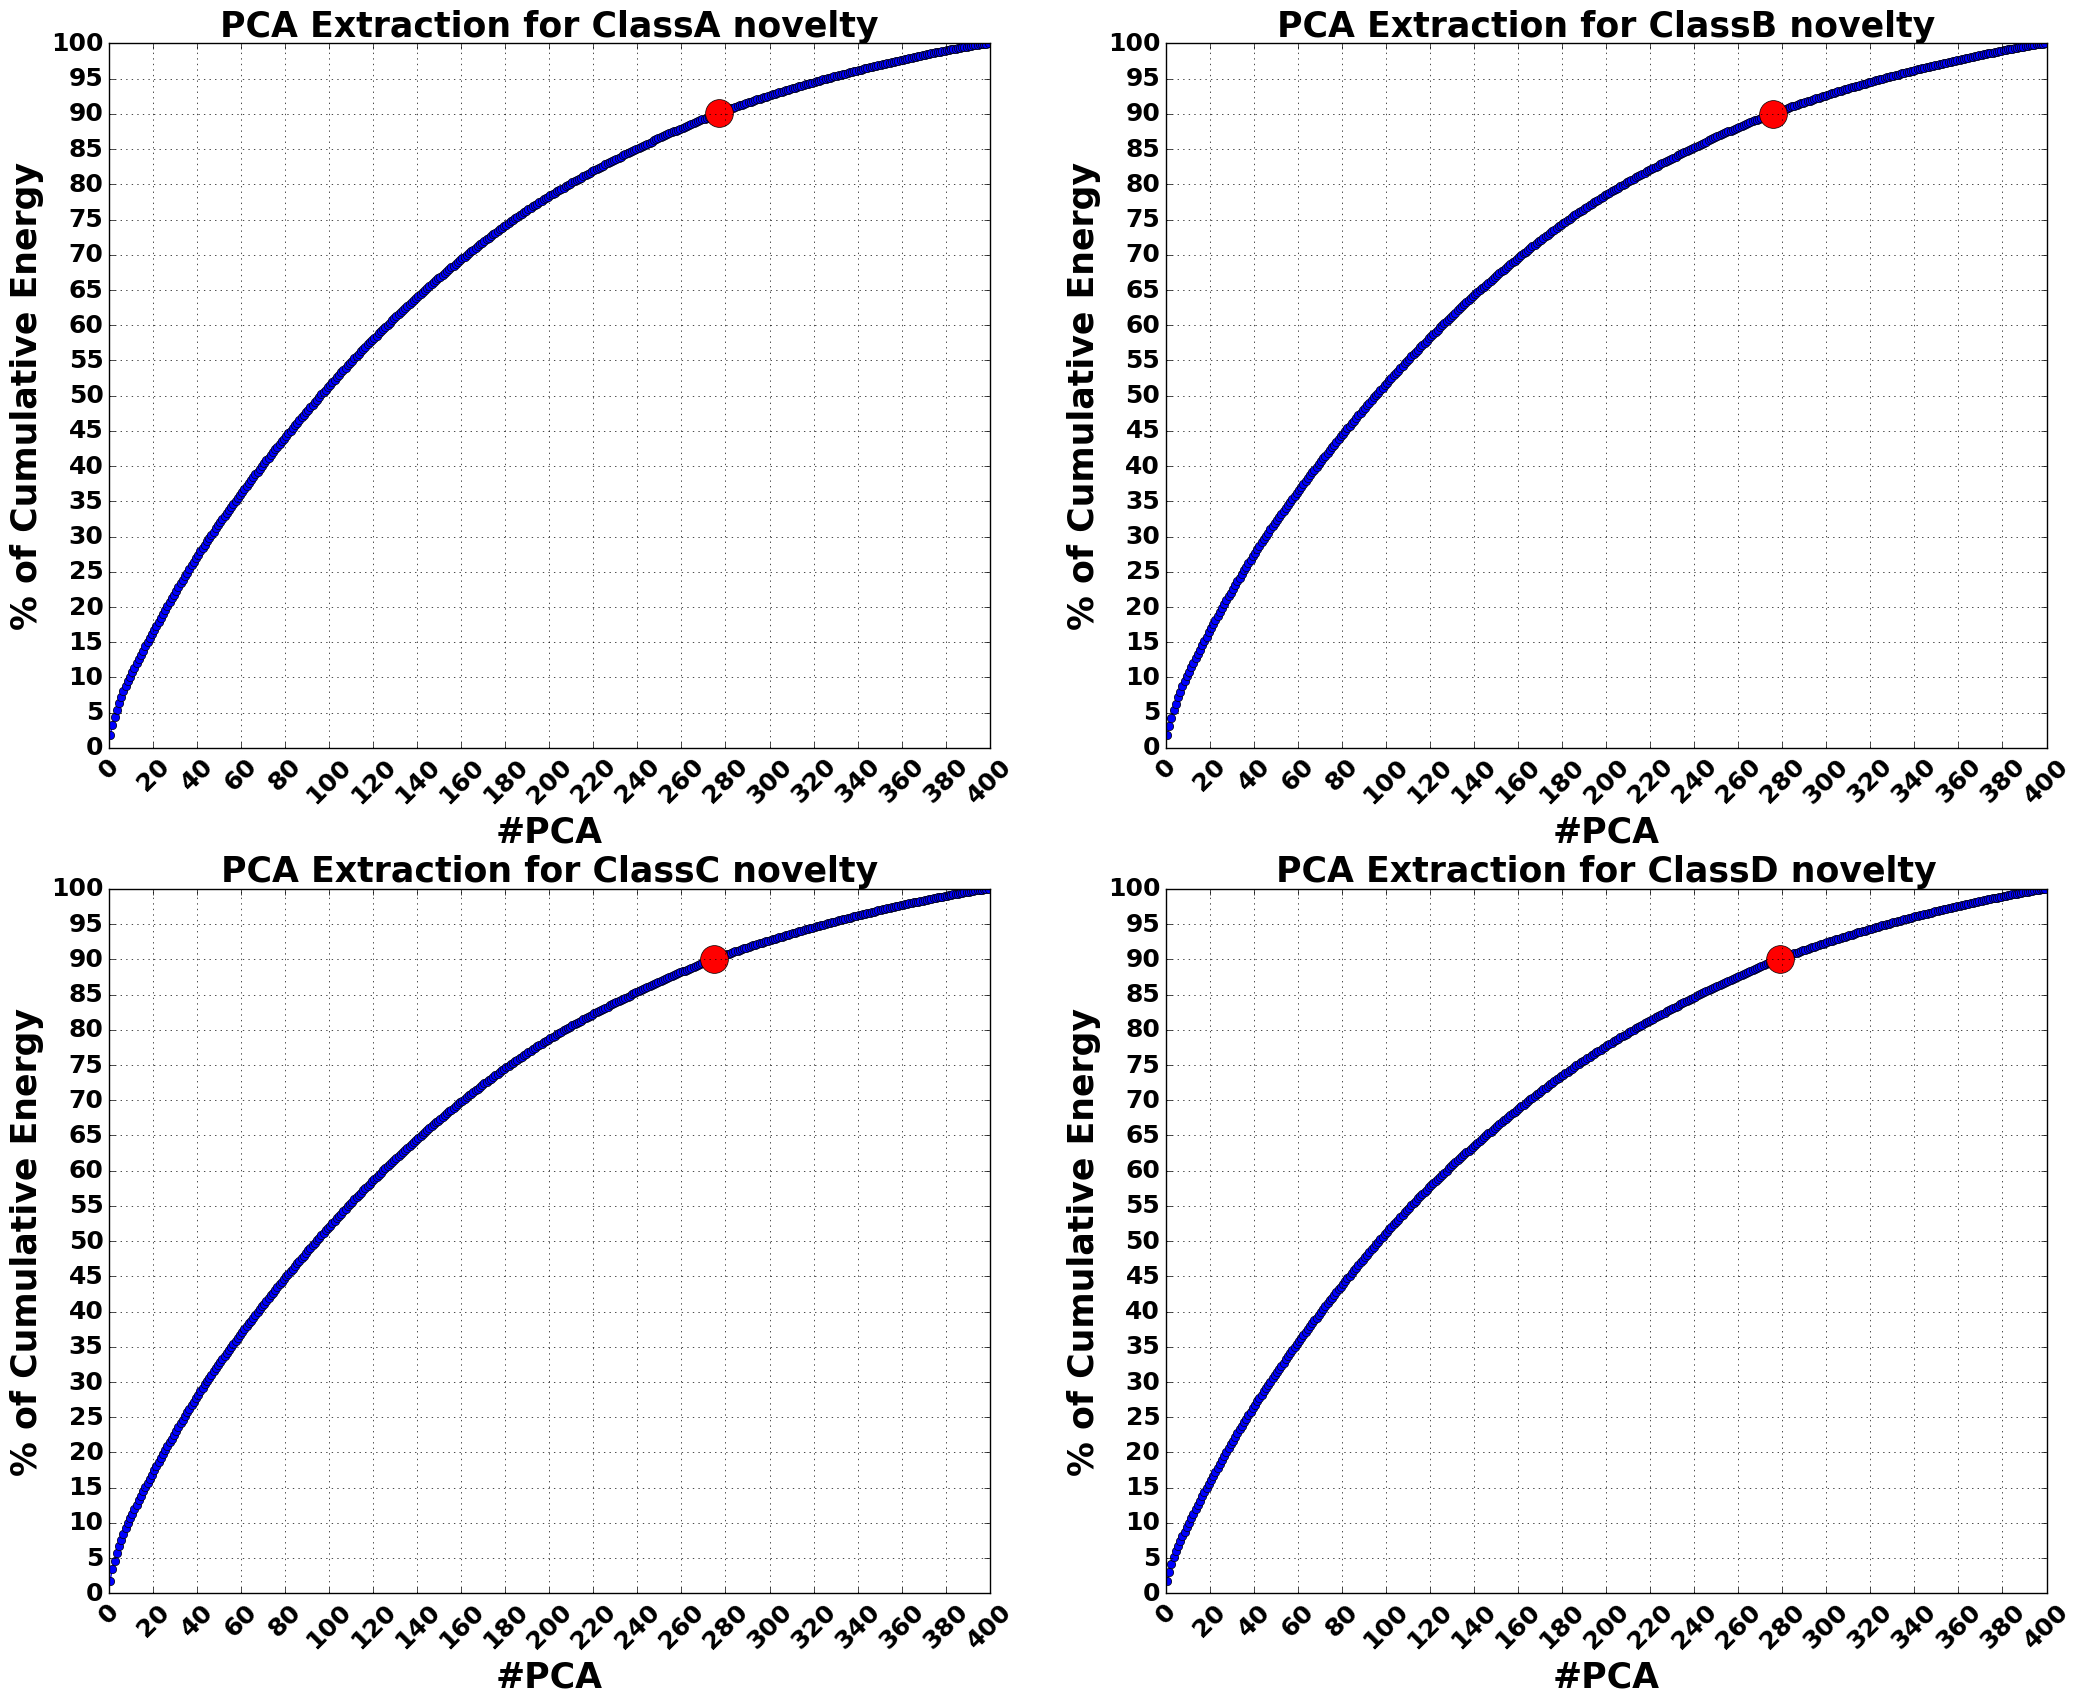

In [45]:
# PCA energy analysis

pcas_energy = {}

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'PCA analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    [pcas] = joblib.load(result_analysis_path+'/result_files'+'/'+date+'_pca_file.jbl')
    
    for novelty_class, novelty_label in enumerate(class_labels): 
        pcas_energy[novelty_class] = np.zeros([train_info['n_folds'],all_data.shape[1]])
        
        for ifold in range(len(train_info['CVO_novelty_%s'%(novelty_label)])):
            pcas_energy[novelty_class][ifold,:] = (pcas[novelty_class][ifold].explained_variance_/
                                                   np.sum(pcas[novelty_class][ifold].explained_variance_))
            
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    
    n_pcas = all_data.shape[1]
    bins = np.linspace(0,n_pcas-1,n_pcas)
    
    n_columns = 2
    icolumn = 0
    
    n_rows = 2
    irow = 0
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_columns,figsize=(25,20))
    
    
    for novelty_class, novelty_label in enumerate(class_labels):
        #ax[irow,icolumn].plot(bins+0.5,100.*np.cumsum(np.mean(pcas_energy[novelty_class].T,1)),'r--')
        ax[irow,icolumn].errorbar(bins+0.5,
                                 100.*np.cumsum(np.mean(pcas_energy[novelty_class].T,1)),
                                 np.std(pcas_energy[novelty_class].T,1),fmt='-o')
        
        for ipca in range(0,n_pcas,1):
            if np.sum(np.mean(pcas_energy[novelty_class].T,1)[0:ipca]) > 0.9:
                break
        ax[irow,icolumn].plot(bins[ipca],100.*np.sum(np.mean(pcas_energy[novelty_class].T,1)[0:ipca]),
                              'ro',markersize=20)
        
        ax[irow,icolumn].set_ylim([0,100])
        
        m_fontsize = 25
        ax[irow,icolumn].set_title('PCA Extraction for %s novelty'%(novelty_label), 
                                   fontsize= m_fontsize, fontweight='bold')
        ax[irow,icolumn].set_ylabel('% of Cumulative Energy', fontsize= m_fontsize, fontweight='bold')
        ax[irow,icolumn].set_xlabel('#PCA', fontsize= m_fontsize, fontweight='bold')
        ax[irow,icolumn].grid()
        
        ax[irow,icolumn].set_yticks([x for x in range(0,101,5)])
        ax[irow,icolumn].set_xticks([x for x in range(0,401,20)])
        ax[irow,icolumn].set_xticklabels([x for x in range(0,401,20)],rotation=45)
                
                
        if icolumn+1 == n_columns:
            icolumn = 0
            irow = irow+1
        else:
            icolumn = icolumn+1
    

# Treinamento - Single Class SVM
Adicionar informações
## Arquivos gerados
Adicionar informações

In [ ]:
# Treinamento

# Classifiers
classifiers = {}


for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'PCA analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    [pcas] = joblib.load(result_analysis_path+'/result_files'+'/'+date+'_pca_file.jbl')
    
    for novelty_class, novelty_label in enumerate(class_labels):
        classifiers[novelty_class] = {}
        
        known_data = all_data[all_trgt!=novelty_class,:]
        known_trgt = all_trgt[all_trgt!=novelty_class]
        
        # for: folds
        for ifold in range(len(train_info['CVO_novelty_%s'%(novelty_label)])):
            classifiers[novelty_class][ifold] = {}
            
            # split data in trn set, tst set
            train_id, test_id = train_info['CVO_novelty_%s'%(novelty_label)][ifold]
            
            # normalize data based in train set
            if train_info['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
        
            norm_known_data = scaler.transform(known_data)
        
            pca_norm_known_data = pcas[novelty_class][ifold].transform(norm_known_data)
            
            #cut some pcas
            pca_norm_known_data = pca_norm_known_data[:,0:train_info['n_pcas']]
        
            for nu_id, nu_value in enumerate(train_info['nu_values']):
                classifiers[novelty_class][ifold][nu_value] = {}
                print 'Training Classifiers: Novelty Class: %s, %i of %i folds, %i of %i nu_values'%(
                    novelty_label, ifold+1, len(train_info['CVO_novelty_%s'%(novelty_label)]),
                    nu_id+1, len(train_info['nu_values'])
                )
                
                # novelty detector
                novelty_detector = svm.OneClassSVM(nu=nu_value, kernel="rbf", gamma=gamma_value)
                novelty_detector.fit(pca_norm_known_data[train_id,:])
                
                classifiers[novelty_class][ifold][nu_value]['NoveltyDetector'] = novelty_detector
                
                # class specialist
                for known_class, known_label in enumerate(class_labels):
                    if known_class == novelty_class: continue
                    class_idx = np.nonzero(known_trgt == known_class)[0]
                    idx = np.intersect1d(class_idx,train_id)
                    classifier = svm.OneClassSVM(nu=nu_value, kernel="rbf", gamma=gamma_value)
                    classifier.fit(pca_norm_known_data[idx,:])
                    classifiers[novelty_class][ifold][nu_value][known_label] = classifier

classifier_info_name = result_analysis_path+'/classifiers_files'+'/'+date+'_classifiers.jbl'
joblib.dump([classifiers],classifier_info_name,compress=9)

PCA analysis performed in 2016_12_22_17_13_21 and for PCASingleClassSVM analysis
Training Classifiers: Novelty Class: ClassA, 1 of 10 folds, 1 of 10 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 10 folds, 2 of 10 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 10 folds, 3 of 10 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 10 folds, 4 of 10 nu_values


In [47]:
pca_norm_known_data.shape

(29343,)